In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
from einops import rearrange, repeat, reduce
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
# Mnist dataset
train_dataset = datasets.MNIST(root="../data", train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root="../data", train=False, download=True, transform=transforms.ToTensor())

# Print the shape of the dataset
print(train_dataset.data.shape)

torch.Size([60000, 28, 28])


In [3]:
class CNNEncoder(nn.Module):
    def __init__(self, in_channels, latent_dim):
        super(CNNEncoder, self).__init__()
        self.layers = nn.Sequential(
            # 1x28x28 -> 32x14x14
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            # 32x14x14 -> 64x7x7
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            # 64x7x7 -> 16
            nn.Flatten(),
            nn.Linear(64*7*7, 16),
            nn.ReLU()
        )
        self.mean_head = nn.Linear(16, latent_dim)
        self.logvar_head = nn.Linear(16, latent_dim)
        
    def forward(self, x):
        x = self.layers(x)
        mean = self.mean_head(x)
        logvar = self.logvar_head(x)
        return mean, logvar
        

def sample(mean, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return mean + eps*std


class CNNDecoder(nn.Module):
    def __init__(self, latent_dim, out_channels):
        super(CNNDecoder, self).__init__()
        self.in_layer = nn.Linear(latent_dim, 64*7*7)
        self.conv_layers = nn.Sequential(
            # 64x7x7 -> 32x14x14
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            # 32x14x14 -> 16x28x28
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            # 16x28x28 -> 1x28x28
            nn.Conv2d(16, out_channels, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.in_layer(x)
        x = x.view(-1, 64, 7, 7)
        x = self.conv_layers(x)
        return x

In [4]:
def loss_fn(recon_x, x, mean, logvar):
    bce = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return torch.mean(bce + kld)

In [16]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
encoder = CNNEncoder(in_channels=1, latent_dim=2).cuda()
decoder = CNNDecoder(latent_dim=2, out_channels=1).cuda()
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)

In [17]:
for epoch in tqdm(range(30)):
    epoch_loss = 0
    batch_count = 0
    for x, _ in train_loader:
        optimizer.zero_grad()
        x = x.cuda()
        mean, logvar = encoder(x)
        z = sample(mean, logvar)
        recon_x = decoder(z)
        loss = loss_fn(recon_x, x, mean, logvar)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        batch_count += train_loader.batch_size
    print(f"Epoch {epoch}, loss: {epoch_loss/batch_count}")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 0, loss: 213.19234813047623
Epoch 1, loss: 175.40758564833132
Epoch 2, loss: 167.12501895148108
Epoch 3, loss: 162.87481160763738
Epoch 4, loss: 160.37580167205095
Epoch 5, loss: 158.90009361543636
Epoch 6, loss: 157.77351387528213
Epoch 7, loss: 156.7666841356485
Epoch 8, loss: 156.02156571182869
Epoch 9, loss: 155.4221477223866
Epoch 10, loss: 154.94737490916302
Epoch 11, loss: 154.40813974734309
Epoch 12, loss: 154.0046352069261
Epoch 13, loss: 153.57241800141486
Epoch 14, loss: 153.26601265132555
Epoch 15, loss: 152.91907917665267
Epoch 16, loss: 152.57644666334204
Epoch 17, loss: 152.3844857287051
Epoch 18, loss: 152.01240842123784
Epoch 19, loss: 151.8084893785814
Epoch 20, loss: 151.62423969586013
Epoch 21, loss: 151.3701008550648
Epoch 22, loss: 151.21298422742245
Epoch 23, loss: 151.09120784995397
Epoch 24, loss: 150.85578479238157
Epoch 25, loss: 150.6721847143763
Epoch 26, loss: 150.55249477297005
Epoch 27, loss: 150.37376317591554
Epoch 28, loss: 150.23968473324643
Ep

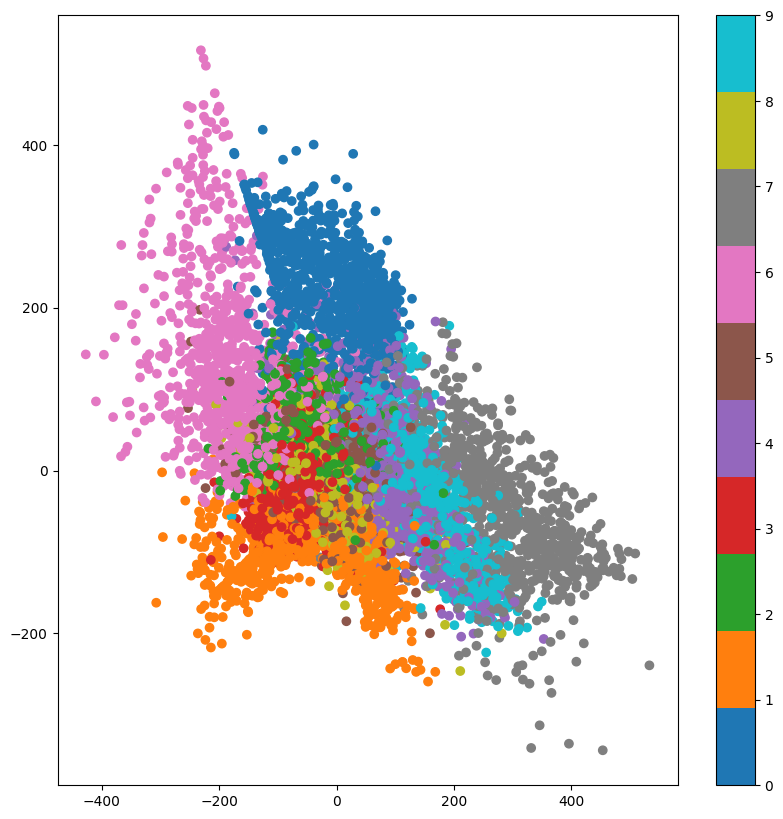

In [18]:
x_test = test_dataset.data.float().view(-1, 1, 28, 28).cuda()
mean, logvar = encoder(x_test)

# Show the latent space with scatter plot
plt.figure(figsize=(10, 10))
mean_np = mean.cpu().detach().numpy()
c_np = test_dataset.targets.numpy()
plt.scatter(mean_np[:, 0], mean_np[:, 1], c=c_np, cmap='tab10')
plt.colorbar()
plt.show()